# **Modelagem Preditiva da Umidade do Solo em Montes Claros/MG**

---

# **1. Importação e Preparação dos Dados**

In [61]:
#%pip install scikit-learn
%pip install control

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.6/549.6 kB 4.7 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [91]:
# Importação de bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from control import place

# Para modelagem e avaliação
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from scipy.optimize import curve_fit

# Para o observador
from scipy.signal import place_poles

# Configuração gráfica
plt.style.use('seaborn-v0_8')
%matplotlib inline

In [75]:
# Leitura dos dados
df = pd.read_csv('../data/processed/chuva_moc.csv')

# Conversão da coluna 'data' para datetime
df['data'] = pd.to_datetime(df['data'], format='%Y-%m-%d')

# Ordenação cronológica
df = df.sort_values('data').reset_index(drop=True)

# Visualização inicial
df.head()

,data,precipitacao_mm,temp_media,umidade_media
0,2003-01-01,7.0,22.8,89.3
1,2003-01-02,11.2,23.0,89.8
2,2003-01-03,7.8,22.4,93.1
3,2003-01-04,52.2,24.1,81.8
4,2003-01-05,20.8,23.0,87.1


In [78]:
df_ppt = df[['data', 'precipitacao_mm']]

In [79]:
df_ppt.head()

,data,precipitacao_mm
0,2003-01-01,7.0
1,2003-01-02,11.2
2,2003-01-03,7.8
3,2003-01-04,52.2
4,2003-01-05,20.8


In [80]:
# Verificação de colunas e tipos
df_ppt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7208 entries, 0 to 7207
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   data             7208 non-null   datetime64[ns]
 1   precipitacao_mm  7208 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 112.8 KB


In [68]:
# Estatísticas descritivas
df_ppt[['precipitacao_mm']].describe()

,precipitacao_mm
count,7208.000000
mean,2.351609
std,8.161729
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,116.800000


In [69]:
# Verificação de valores ausentes
df_ppt.isna().sum()

data               0
precipitacao_mm    0
dtype: int64

## **Gráficos exploratórios**

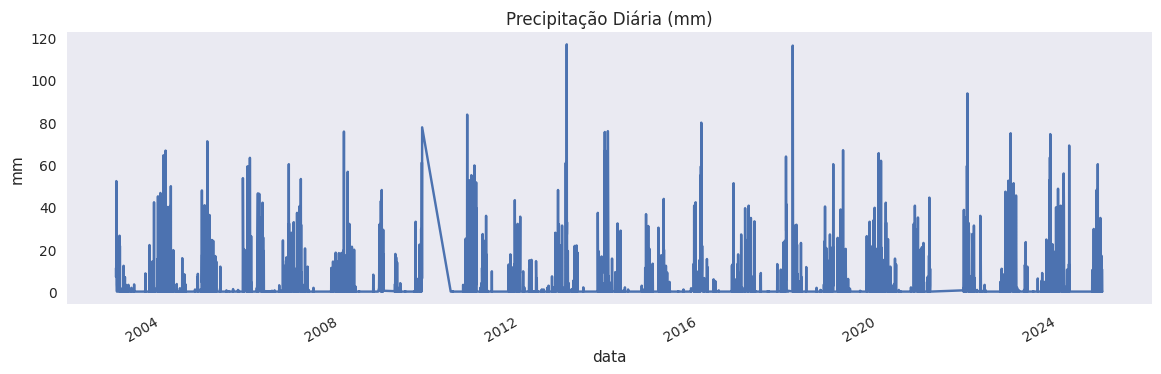

In [ ]:
# Série temporal de precipitação 
df_ppt.set_index('data')['precipitacao_mm'].plot(figsize=(14,4), title='Precipitação Diária (mm)')
plt.ylabel('mm')
plt.grid()
plt.show()

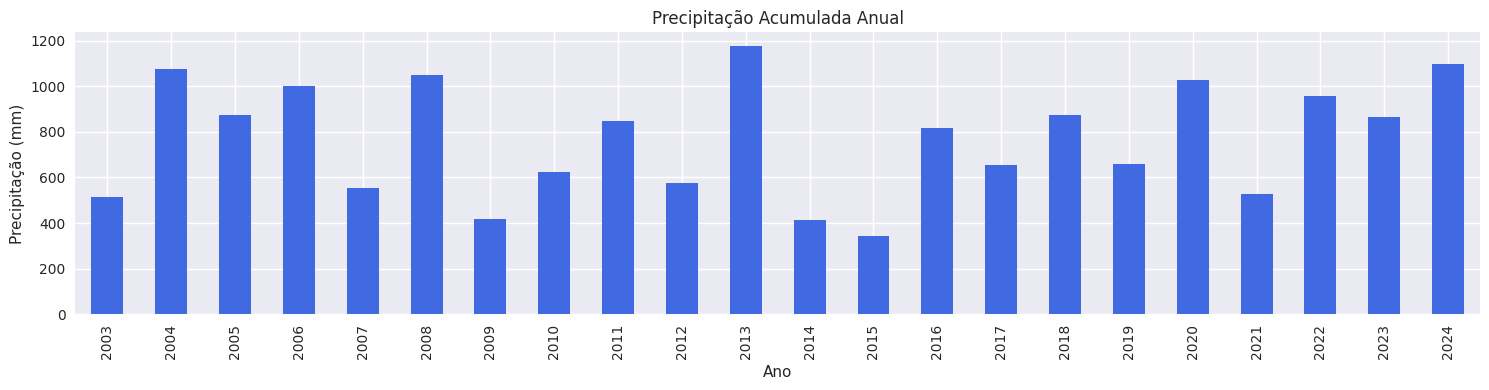

In [83]:
# Agrupamento por ano
df_ppt['ano'] = df_ppt['data'].dt.to_period('Y')

# Soma a precipitação por ano
precip_acumulada_mensal = df_ppt.groupby('ano')['precipitacao_mm'].sum()

# Plot
plt.figure(figsize=(15,4))
precip_acumulada_mensal.plot(kind='bar', color='royalblue')
plt.title('Precipitação Acumulada Anual')
plt.ylabel('Precipitação (mm)')
plt.xlabel('Ano')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

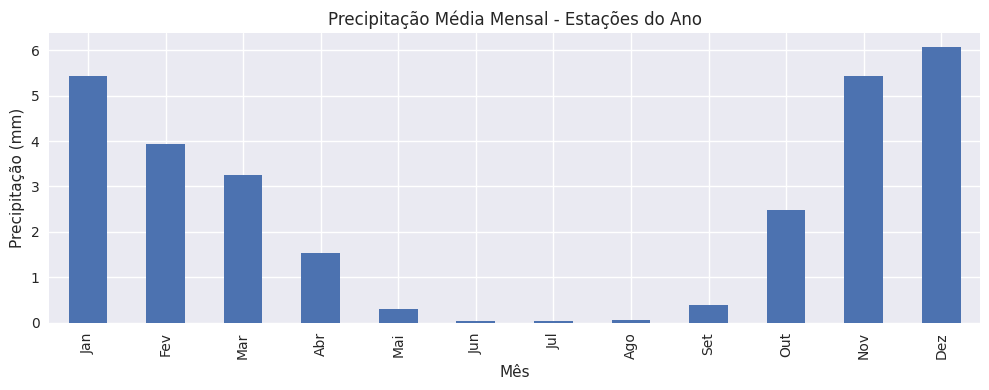

In [84]:
# Identificação visual da estação seca e chuvosa
df_ppt['mes'] = df_ppt['data'].dt.month
df_ppt.groupby('mes')[['precipitacao_mm']].mean().plot(kind='bar', figsize=(10,4), legend=False)
plt.title('Precipitação Média Mensal - Estações do Ano')
plt.ylabel('Precipitação (mm)')
plt.xlabel('Mês')
plt.xticks(ticks=range(0,12), labels=[
    'Jan', 'Fev', 'Mar', 'Abr', 'Mai', 'Jun',
    'Jul', 'Ago', 'Set', 'Out', 'Nov', 'Dez'])
plt.grid(True)
plt.tight_layout()
plt.show()

# **2. Simulação da Umidade Superficial do Solo (modelo empírico)**

>**Objetivo**: simular a umidade superficial do solo com um *modelo empírico* simples.

### **2.1 Modelo de balanço hídrico:**

>A umidade superficial do solo será aproximada por um modelo que acumula a chuva recente e decai exponencialmente com o tempo em períodos secos:

$$
\theta(t) = \theta(t-1) \cdot e^{-\lambda} + \alpha \cdot \text{prec}(t)
$$

Onde:

- $\theta(t)$: umidade do solo no tempo $t$;
- $\lambda$: taxa de perda de umidade por evaporação e drenagem;
- $\alpha$: fator de absorção da chuva;
- $\text{prec}(t)$: precipitação diária.

### **2.2 Construção da variável estimada de umidade do solo**

In [85]:
def estimar_umidade_solo(prec, alpha, lambd):
    theta = [0]
    for t in range(1, len(prec)):
        theta.append(theta[-1]*np.exp(-lambd) + alpha * prec[t])
    return np.array(theta)

# **3.  Calibração Empírica dos Parâmetros**

Como não temos dados reais de umidade do solo para ajustar, podemos **calibrar parâmetros razoáveis**:

- $\lambda$: taxa de perda (evaporação + percolação). *Valores típicos entre 0.01 a 0.1*
- $\alpha$: eficiência de infiltração da chuva *(0.1 a 0.4, dependendo do solo)*

In [86]:
# Parâmetros calibrados empiricamente
alpha = 0.25   # parte da chuva que vira umidade
lambd = 0.03   # taxa de perda diária

# Estima a umidade
df_ppt['umidade_solo_simulada'] = estimar_umidade_solo(df_ppt['precipitacao_mm'].values, alpha, lambd)

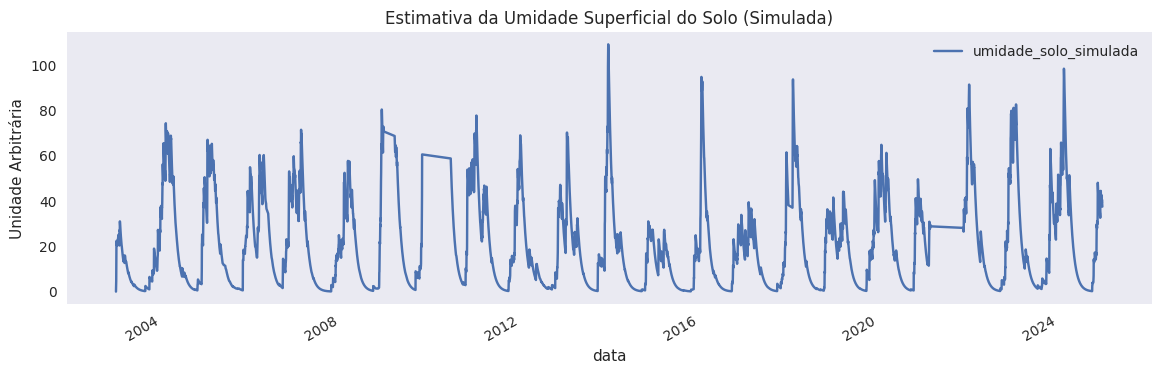

In [87]:
# Visualização
df_ppt.set_index('data')[['umidade_solo_simulada']].plot(figsize=(14,4), title='Estimativa da Umidade Superficial do Solo (Simulada)')
plt.ylabel('Unidade Arbitrária')
plt.grid()
plt.show()

#  **4. Validação com observador de Luenberger**

> Objetivo: Validar se é possível estimar $\hat{x}(t)$ (umidade do solo) com base apenas na entrada (chuva) e saída simulada.


- Definindo o modelo:

    $$
    x(t+1) = A \cdot x(t) + B \cdot u(t)
    $$

    Onde:

    - $A = e^{-\lambda}$,
    - $B = \alpha$,
    - $u(t) = \text{prec}(t)$,
    - $x(t)$ representa a umidade do solo estimada.
    - A saída é:

    $$
    y(t) = C \cdot x(t)
    $$

- E o observador:

    $$
    \hat{x}(t+1) = A \hat{x}(t) + B u(t) + L(y(t) - \hat{x}(t))
    $$

In [ ]:
# Matriz do sistema
A = np.array([[np.exp(-lambd)]])
B = np.array([[alpha]])
C = np.array([[1]])

In [94]:
# Simulação do observador
u = df_ppt['precipitacao_mm'].values
y = df_ppt['umidade_solo_simulada'].values

# Inicializações
x_real = [0]
x_obs = [5.0]  # estimativa inicial incorreta para avaliar convergência

# Ganho do observador (L) via posicionamento de polos
polo_desejado = 0.4
L = place(A.T, C.T, [polo_desejado]).T

In [101]:
print(L)

[[0.57044553]]


In [95]:
# Simulação
for t in range(1, len(u)):
    # Sistema real
    x_next = A @ np.array([[x_real[-1]]]) + B @ np.array([[u[t]]])
    x_real.append(x_next[0, 0])

    # Observador
    y_hat = C @ np.array([[x_obs[-1]]])
    x_obs_next = A @ np.array([[x_obs[-1]]]) + B @ np.array([[u[t]]]) + L @ (y[t] - y_hat)
    x_obs.append(x_obs_next[0, 0])

x_real = np.array(x_real)
x_obs = np.array(x_obs)
erro = x_real - x_obs

# **5. Resultados**

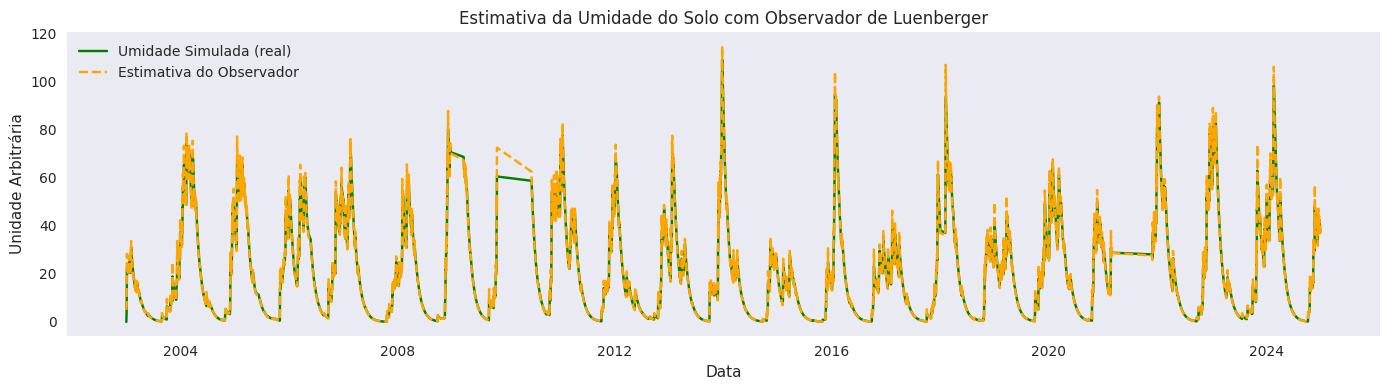

In [98]:
# Comparação
plt.figure(figsize=(14,4))
plt.plot(df_ppt['data'], x_real, label='Umidade Simulada (real)', color='green')
plt.plot(df_ppt['data'], x_obs, label='Estimativa do Observador', linestyle='--', color='orange')
plt.title('Estimativa da Umidade do Solo com Observador de Luenberger')
plt.xlabel('Data')
plt.ylabel('Unidade Arbitrária')
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

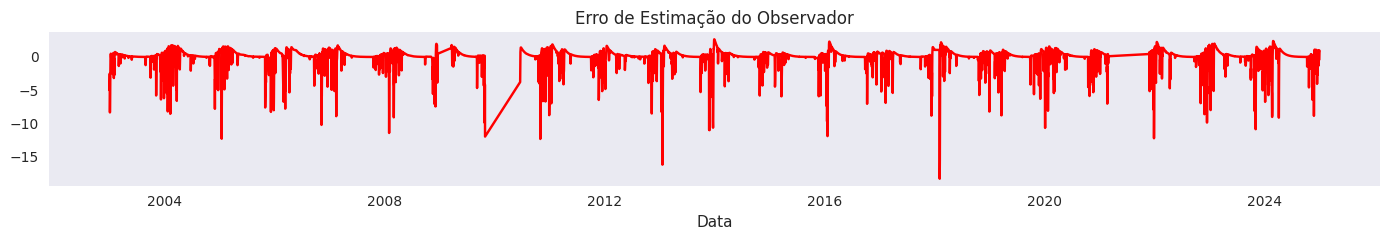

In [99]:
# Erro
plt.figure(figsize=(14,2.5))
plt.plot(df_ppt['data'], erro, color='red')
plt.title('Erro de Estimação do Observador')
plt.xlabel('Data')
plt.grid()
plt.tight_layout()
plt.show()

In [104]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Valores reais e estimados
x_real = np.array(x_real)
x_obs = np.array(x_obs)
erro = x_real - x_obs

# Cálculo das métricas
mae = mean_absolute_error(x_real, x_obs)
rmse = np.sqrt(mean_squared_error(x_real, x_obs))
bias = np.mean(erro)

# Impressão dos resultados
print(f"Avaliação da Estimativa do Observador:")
print(f"MAE (Erro Médio Absoluto): {mae:.3f}")
print(f"RMSE (Raiz do Erro Quadrático Médio): {rmse:.3f}")
print(f"Erro Médio (Bias): {bias:.3f}")

Avaliação da Estimativa do Observador:
MAE (Erro Médio Absoluto): 0.701
RMSE (Raiz do Erro Quadrático Médio): 1.411
Erro Médio (Bias): -0.006
